# IndShockConsumerType Documentation
## Consumption-Saving model with Idiosyncratic Income Shocks

In [1]:
# Initial imports and notebook setup, click arrow to show
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs
from time import clock
import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

The module $\texttt{HARK.ConsumptionSaving.ConsIndShockModel}$ concerns consumption-saving models with idiosyncratic shocks to (non-capital) income.  All of the models assume CRRA utility with geometric discounting, no bequest motive, and income shocks are fully transitory or fully permanent.

$\texttt{ConsIndShockModel}$ includes:
1. A very basic "perfect foresight" model with no uncertainty.
2. A model with risk over transitory and permanent income shocks.
3. The model described in (2), with an interest rate for debt that differs from the interest rate for savings.

This notebook provides documentation for the second of these models.
$\newcommand{\CRRA}{\rho}$
$\newcommand{\DiePrb}{\mathsf{D}}$
$\newcommand{\PermGroFac}{\Gamma}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$

## Statement of idiosyncratic income shocks model

Suppose we want to solve a model like the one analyzed in [BufferStockTheory](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/), which has all the same features as the perfect foresight consumer, plus idiosyncratic shocks to income each period.  Agents with this kind of model are represented by the class $\texttt{IndShockConsumerType}$.

Specifically, this type of consumer receives two income shocks at the beginning of each period: a completely transitory shock $\newcommand{\tShkEmp}{\theta}{\tShkEmp_t}$ and a completely permanent shock $\newcommand{\pShk}{\psi}{\pShk_t}$.  Moreover, the agent is subject to borrowing a borrowing limit: the ratio of end-of-period assets $A_t$ to permanent income $P_t$ must be greater than $\underline{a}$.  As with the perfect foresight problem, this model is stated in terms of *normalized* variables, dividing all real variables by $P_t$:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} u(c_t) + \DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ (\PermGroFac_{t+1}\psi_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\underline{a}$}, \\
m_{t+1} &=& \Rfree/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

## Solution method for IndShockConsumerType

With the introduction of (non-trivial) risk, the idiosyncratic income shocks model has no closed form solution and must be solved numerically.  The function $\texttt{solveConsIndShock}$ solves the one period problem for the $\texttt{IndShockConsumerType}$ class.  To do so, HARK uses the original version of the endogenous grid method (EGM) first described [here](http://www.econ2.jhu.edu/people/ccarroll/EndogenousGridpoints.pdf) <cite data-cite="6202365/HQ6H9JEI"></cite>; see also the [SolvingMicroDSOPs](http://www.econ2.jhu.edu/people/ccarroll/SolvingMicroDSOPs/) lecture notes. 

Briefly, the transition equation for $m_{t+1}$ can be substituted into the problem definition; the second term of the reformulated maximand represents "end of period value of assets" $\mathfrak{v}_t(a_t)$ ("Gothic v"):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} u(c_t) + \underbrace{\DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ (\PermGroFac_{t+1}\psi_{t+1})^{1-\CRRA} v_{t+1}(\Rfree/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}) \right]}_{\equiv \mathfrak{v}_t(a_t)}.
\end{eqnarray*}

The first order condition with respect to $c_t$ is thus simply:

\begin{eqnarray*}
u^{\prime}(c_t) - \mathfrak{v}'_t(a_t) = 0 \Longrightarrow c_t^{-\CRRA} = \mathfrak{v}'_t(a_t) \Longrightarrow c_t = \mathfrak{v}'_t(a_t)^{-1/\CRRA},
\end{eqnarray*}

and the marginal value of end-of-period assets can be computed as:

\begin{eqnarray*}
\mathfrak{v}'_t(a_t) = \DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ \Rfree (\PermGroFac_{t+1}\psi_{t+1})^{-\CRRA} v'_{t+1}(\Rfree/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}) \right].
\end{eqnarray*}

To solve the model, we choose an exogenous grid of $a_t$ values that spans the range of values that could plausibly be achieved, compute $\mathfrak{v}'_t(a_t)$ at each of these points, calculate the value of consumption $c_t$ whose marginal utility is consistent with the marginal value of assets, then find the endogenous $m_t$ gridpoint as $m_t = a_t + c_t$.  The set of $(m_t,c_t)$ gridpoints is then interpolated to construct the consumption function.

## Example parameter values to construct an instance of IndShockConsumerType

In order to create an instance of $\texttt{IndShockConsumerType}$, the user must specify parameters that characterize the (age-varying) distribution of income shocks $F_{t+1}$, the artificial borrowing constraint $\underline{a}$, and the exogenous grid of end-of-period assets-above-minimum for use by EGM, along with all of the parameters for the perfect foresight model.  The table below presents the complete list of parameter values required to instantiate an $\texttt{IndShockConsumerType}$, along with example values.

| Parameter | Description | Code | Example value | Time-varying? |
| :---: | --- | --- | --- | --- |
| $\DiscFac$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | $0.96$ |  |
| $\CRRA$|Coefficient of relative risk aversion | $\texttt{CRRA}$ | $2.0$ | |
| $\Rfree$ | Risk free interest factor | $\texttt{Rfree}$ | $1.03$ | |
| $1 - \DiePrb_{t+1}$ |Survival probability | $\texttt{LivPrb}$ | $[0.98]$ | $\surd$ |
|$\PermGroFac_{t+1}$|Permanent income growth factor|$\texttt{PermGroFac}$| $[1.01]$ | $\surd$ |
| $\sigma_\psi$| Standard deviation of log permanent income shocks | $\texttt{PermShkStd}$ | $[0.1]$ |$\surd$ |
| $N_\psi$| Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | $7$ | |
| $\sigma_\theta$| Standard deviation of log transitory income shocks | $\texttt{TranShkStd}$ | $[0.2]$ | $\surd$ |
| $N_\theta$| Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | $7$ |  |
| $\mho$ | Probability of being unemployed and getting $\theta=\underline{\theta}$ | $\texttt{UnempPrb}$ | $0.05$ |  |
| $\underline{\theta}$| Transitory shock when unemployed | $\texttt{IncUnemp}$ | $0.3$ |  |
| $\mho^{Ret}$ | Probability of being "unemployed" when retired | $\texttt{UnempPrb}$ | $0.0005$ |  |
| $\underline{\theta}^{Ret}$| Transitory shock when "unemployed" and retired | $\texttt{IncUnemp}$ | $0.0$ |  |
| $(none)$ | Period of the lifecycle model when retirement begins | $\texttt{T_retire}$ | $0$ | |
| $(none)$ | Minimum value in assets-above-minimum grid | $\texttt{aXtraMin}$ | $0.001$ | |
| $(none)$ | Maximum value in assets-above-minimum grid | $\texttt{aXtraMax}$ | $20.0$ | |
| $(none)$ | Number of points in base assets-above-minimum grid | $\texttt{aXtraCount}$ | $48$ | |
| $(none)$ | Exponential nesting factor for base assets-above-minimum grid | $\texttt{aXtraNestFac}$ | $3$ | |
| $(none)$ | Additional values to add to assets-above-minimum grid | $\texttt{aXtraExtra}$ | $None$ | |
| $\underline{a}$| Artificial borrowing constraint (normalized) | $\texttt{BoroCnstArt}$ | $0.0$ | |
| $(none)$|Indicator for whether $\texttt{vFunc}$ should be computed | $\texttt{vFuncBool}$ | $True$ | |
| $(none)$ |Indicator for whether $\texttt{cFunc}$ should use cubic splines | $\texttt{CubicBool}$ | $False$ |  |
|$T$| Number of periods in this type's "cycle" |$\texttt{T_cycle}$| $1$ | |
|(none)| Number of times the "cycle" occurs |$\texttt{cycles}$| $0$ | |

In [2]:
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "PermGroFac" :[1.01],                  # Permanent income growth factor
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

The distribution of permanent income shocks is specified as mean one lognormal, with an age-varying (underlying) standard deviation. The distribution of transitory income shocks is also mean one lognormal, but with an additional point mass representing unemployment; the transitory shocks are adjusted so that the distribution is still mean one.  The continuous distributions are discretized with an equiprobable distribution.

Optionally, the user can specify the period when the individual retires and escapes essentially all income risk as $\texttt{T_retire}$; this can be turned off by setting the parameter to $0$.  In retirement, all permanent income shocks are turned off, and the only transitory shock is an "unemployment" shock, likely with small probability; this prevents the retired problem from degenerating into a perfect foresight model.

The grid of assets above minimum $\texttt{aXtraGrid}$ is specified by its minimum and maximum level, the number of gridpoints, and the extent of exponential nesting.  The greater the (integer) value of $\texttt{aXtraNestFac}$, the more dense the gridpoints will be at the bottom of the grid (and more sparse near the top); setting $\texttt{aXtraNestFac}$ to $0$ will generate an evenly spaced grid of $a_t$.

The artificial borrowing constraint $\texttt{BoroCnstArt}$ can be set to $\texttt{None}$ to turn it off.

It is not necessary to compute the value function in this model, and it is not computationally free to do so.  You can choose whether the value function should be calculated and returned as part of the solution of the model with $\texttt{vFuncBool}$.  The consumption function will be constructed as a piecewise linear interpolation when $\texttt{CubicBool}$ is \texttt{False}, and will be a piecewise cubic spline interpolator if $\texttt{True}$.

## Solving and examining the solution of the idiosyncratic income shocks model

The cell below creates an infinite horizon instance of $\texttt{IndShockConsumerType}$ and solves its model by calling its $\texttt{solve}$ method.

In [3]:
IndShockExample = IndShockConsumerType(**IdiosyncDict)
IndShockExample.cycles = 0 # Make this type have an infinite horizon
IndShockExample.solve()

After solving the model, we can examine an element of this type's $\texttt{solution}$:

In [4]:
print(vars(IndShockExample.solution[0]))

{'cFunc': <HARK.interpolation.LowerEnvelope object at 0x7fba58210d68>, 'vFunc': <HARK.ConsumptionSaving.ConsIndShockModel.ValueFunc object at 0x7fba68c9c9b0>, 'vPfunc': <HARK.ConsumptionSaving.ConsIndShockModel.MargValueFunc object at 0x7fba582107b8>, 'vPPfunc': <HARK.utilities.NullFunc object at 0x7fba58210f98>, 'mNrmMin': 0.0, 'hNrm': 44.991920196607595, 'MPCmin': 0.044536273404377116, 'MPCmax': 1.0, 'mNrmSS': 1.5488165705077026}


The single-period solution to an idiosyncratic shocks consumer's problem has all of the same attributes as in the perfect foresight model, with a couple additions.  The solution can include the marginal marginal value of market resources function $\texttt{vPPfunc}$, but this is only constructed if $\texttt{CubicBool}$ is $\texttt{True}$, so that the MPC can be accurately computed; when it is $\texttt{False}$, then $\texttt{vPPfunc}$ merely returns $\texttt{NaN}$ everywhere.

The $\texttt{solveConsIndShock}$ function calculates steady state market resources and stores it in the attribute $\texttt{mNrmSS}$.  This represents the steady state level of $m_t$ if *this period* were to occur indefinitely, but with income shocks turned off.  This is relevant in a "one period infinite horizon" model like we've specified here, but is less useful in a lifecycle model.

Let's take a look at the consumption function by plotting it, along with its derivative (the MPC):

Consumption function for an idiosyncratic shocks consumer type:


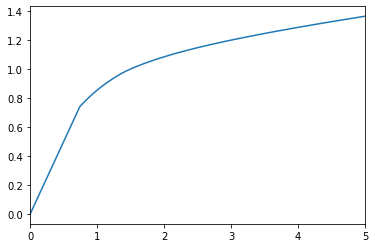

Marginal propensity to consume for an idiosyncratic shocks consumer type:


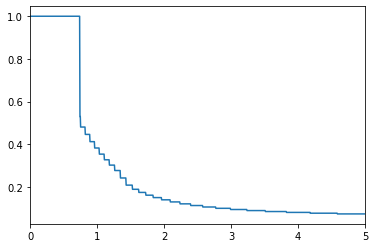

In [5]:
print('Consumption function for an idiosyncratic shocks consumer type:')
plotFuncs(IndShockExample.solution[0].cFunc,IndShockExample.solution[0].mNrmMin,5)
print('Marginal propensity to consume for an idiosyncratic shocks consumer type:')
plotFuncsDer(IndShockExample.solution[0].cFunc,IndShockExample.solution[0].mNrmMin,5)

The lower part of the consumption function is linear with a slope of 1, representing the *constrained* part of the consumption function where the consumer *would like* to consume more by borrowing-- his marginal utility of consumption exceeds the marginal value of assets-- but he is prevented from doing so by the artificial borrowing constraint.

The MPC is a step function, as the $\texttt{cFunc}$ itself is a piecewise linear function; note the large jump in the MPC where the borrowing constraint begins to bind.

If you want to look at the interpolation nodes for the consumption function, these can be found by "digging into" attributes of $\texttt{cFunc}$:

In [6]:
print('mNrmGrid for unconstrained cFunc is ',IndShockExample.solution[0].cFunc.functions[0].x_list)
print('cNrmGrid for unconstrained cFunc is ',IndShockExample.solution[0].cFunc.functions[0].y_list)
print('mNrmGrid for borrowing constrained cFunc is ',IndShockExample.solution[0].cFunc.functions[1].x_list)
print('cNrmGrid for borrowing constrained cFunc is ',IndShockExample.solution[0].cFunc.functions[1].y_list)

mNrmGrid for unconstrained cFunc is  [-0.25017509 -0.23682357 -0.04309334  0.08570877  0.19249704  0.28773035
  0.37527975  0.4572262   0.53458817  0.60902763  0.68157147  0.75266421
  0.82159155  0.89091324  0.96108615  1.03297006  1.10702535  1.18386894
  1.26405846  1.34797683  1.43498517  1.52575439  1.62247992  1.7264799
  1.83886328  1.96091089  2.09399047  2.23965509  2.39978161  2.57666105
  2.77296758  2.99185309  3.23706867  3.51312387  3.82546834  4.18073875
  4.58704087  5.05438059  5.59517832  6.2249668   6.96332613  7.83514604
  8.87231638 10.11613869 11.62057399 13.45688075 15.72024305 18.53939481
 22.09098021]
cNrmGrid for unconstrained cFunc is  [0.         0.01235151 0.18691037 0.29541926 0.38070319 0.45312275
 0.51644051 0.57261755 0.62253956 0.66772112 0.70902525 0.74671381
 0.77986847 0.81082056 0.8397706  0.86728992 0.89351353 0.91869035
 0.94296058 0.9662323  0.98732483 1.00628889 1.02460772 1.04277873
 1.06096172 1.07933575 1.0979846  1.11695897 1.13637025 1.156

The consumption function in this model is an instance of $\texttt{LowerEnvelope1D}$, a class that takes an arbitrary number of 1D interpolants as arguments to its initialization method.  When called, a $\texttt{LowerEnvelope1D}$ evaluates each of its component functions and returns the lowest value.  Here, the two component functions are the *unconstrained* consumption function-- how the agent would consume if the artificial borrowing constraint did not exist for *just this period*-- and the *borrowing constrained* consumption function-- how much he would consume if the artificial borrowing constraint is binding.  

The *actual* consumption function is the lower of these two functions, pointwise.  We can see this by plotting the component functions on the same figure:

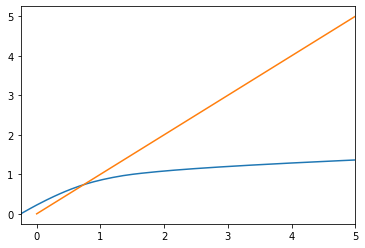

In [7]:
plotFuncs(IndShockExample.solution[0].cFunc.functions,-0.25,5.)

## Simulating the idiosyncratic income shocks model

In order to generate simulated data, an instance of $\texttt{IndShockConsumerType}$ needs to know how many agents there are that share these particular parameters (and are thus *ex ante* homogeneous), the distribution of states for newly "born" agents, and how many periods to simulated.  These simulation parameters are described in the table below, along with example values.

| Description | Code | Example value |
| :---: | --- | --- |
| Number of consumers of this type | $\texttt{AgentCount}$ | $10000$ |
| Number of periods to simulate | $\texttt{T_sim}$ | $120$ |
| Mean of initial log (normalized) assets | $\texttt{aNrmInitMean}$ | $-6.0$ |
| Stdev of initial log  (normalized) assets | $\texttt{aNrmInitStd}$ | $1.0$ |
| Mean of initial log permanent income | $\texttt{pLvlInitMean}$ | $0.0$ |
| Stdev of initial log permanent income | $\texttt{pLvlInitStd}$ | $0.0$ |
| Aggregrate productivity growth factor | $\texttt{PermGroFacAgg}$ | $1.0$ |
| Age after which consumers are automatically killed | $\texttt{T_age}$ | $None$ |

Here, we will simulate 10,000 consumers for 120 periods.  All newly born agents will start with permanent income of exactly $P_t = 1.0 = \exp(\texttt{pLvlInitMean})$, as $\texttt{pLvlInitStd}$ has been set to zero; they will have essentially zero assets at birth, as $\texttt{aNrmInitMean}$ is $-6.0$; assets will be less than $1\%$ of permanent income at birth.

These example parameter values were already passed as part of the parameter dictionary that we used to create $\texttt{IndShockExample}$, so it is ready to simulate.  We need to set the $\texttt{track_vars}$ attribute to indicate the variables for which we want to record a *history*.

In [8]:
IndShockExample.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow']
IndShockExample.initializeSim()
IndShockExample.simulate()

We can now look at the simulated data in aggregate or at the individual consumer level.  Like in the perfect foresight model, we can plot average (normalized) market resources over time, as well as average consumption:

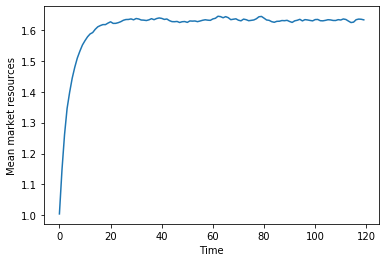

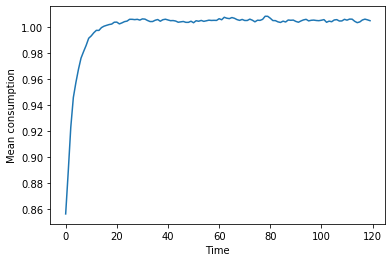

In [9]:
plt.plot(np.mean(IndShockExample.mNrmNow_hist,axis=1))
plt.xlabel('Time')
plt.ylabel('Mean market resources')
plt.show()

plt.plot(np.mean(IndShockExample.cNrmNow_hist,axis=1))
plt.xlabel('Time')
plt.ylabel('Mean consumption')
plt.show()

We could also plot individual consumption paths for some of the consumers-- say, the first five:

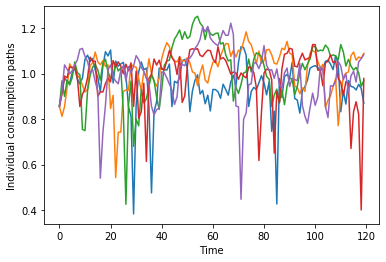

In [10]:
plt.plot(IndShockExample.cNrmNow_hist[:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual consumption paths')
plt.show()

## Other example specifications of idiosyncratic income shocks consumers

$\texttt{IndShockConsumerType}$-- and $\texttt{HARK}$ in general-- can also represent models that are not infinite horizon.  

### Lifecycle example

Suppose we wanted to represent consumers with a *lifecycle*-- parameter values that differ by age, with a finite end point beyond which the individual cannot surive.  This can be done very easily by simply specifying the time-varying attributes $\texttt{PermGroFac}$, $\texttt{LivPrb}$, $\texttt{PermShkStd}$, and $\texttt{TranShkStd}$ as Python *lists* specifying the sequence of periods these agents will experience, from beginning to end.

In the cell below, we define a parameter dictionary for a rather short ten period lifecycle, with arbitrarily chosen parameters.  For a more realistically calibrated (and much longer) lifecycle model, see the [SolvingMicroDSOPs REMARK](https://github.com/econ-ark/REMARK/blob/master/REMARKs/SolvingMicroDSOPs.md).

In [11]:
LifecycleDict={ # Click arrow to expand this fairly large parameter dictionary
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1],
    "PermGroFac" : [1.01,1.01,1.01,1.02,1.02,1.02,0.7,1.0,1.0,1.0],
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0],
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0],
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 7,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 10,                        # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : 11,                          # Age after which simulated agents are automatically killed     
}

In this case, we have specified a ten period model in which retirement happens in period $t=7$.  Agents in this model are more likely to die as they age, and their permanent income drops by 30\% at retirement.  Let's make and solve this lifecycle example, then look at the $\texttt{solution}$ attribute.

In [12]:
LifecycleExample = IndShockConsumerType(**LifecycleDict)
LifecycleExample.cycles = 1 # Make this consumer live a sequence of periods -- a lifetime -- exactly once
LifecycleExample.solve()
print('First element of solution is',LifecycleExample.solution[0])
print('Solution has', len(LifecycleExample.solution),'elements.')

First element of solution is <HARK.ConsumptionSaving.ConsIndShockModel.ConsumerSolution object at 0x7fba18115a90>
Solution has 11 elements.


This was supposed to be a *ten* period lifecycle model-- why does our consumer type have *eleven* elements in its $\texttt{solution}$?  It would be more precise to say that this specification has ten *non-terminal* periods. The solution to the 11th and final period in the model would be the same for every set of parameters: consume $c_t = m_t$, because there is no future.  In a lifecycle model, the terminal period is assumed to exist; the $\texttt{LivPrb}$ parameter does not need to end with a $0.0$ in order to guarantee that survivors die.

We can quickly plot the consumption functions in each period of the model:

Consumption functions across the lifecycle:


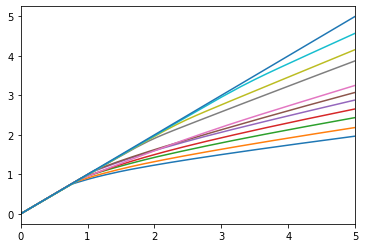

In [13]:
print('Consumption functions across the lifecycle:')
mMin = np.min([LifecycleExample.solution[t].mNrmMin for t in range(LifecycleExample.T_cycle)])
LifecycleExample.unpackcFunc() # This makes all of the cFuncs accessible in the attribute cFunc
plotFuncs(LifecycleExample.cFunc,mMin,5)

### "Cyclical" example

We can also model consumers who face an infinite horizon, but who do *not* face the same problem in every period.  Consider someone who works as a ski instructor: they make most of their income for the year in the winter, and make very little money in the other three seasons.

We can represent this type of individual as a four period, infinite horizon model in which expected "permanent" income growth varies greatly across seasons.

Designating the quarter of the year by $(0,1,2,3)$, so that $\bullet_{t,i}$ is the object $\bullet$ in the $i$'th quarter of year $t$, there will be parallel Bellman equations for each quarter:

<!-- MNW proposes that in python we could alternatively do something like this:
```
v[age].0
v[age].1
v[age].2
v[age].3
```
-->

\begin{eqnarray*}\renewcommand{\LivPrb}{(1-\DiePrb)}
   v_{t,0}(m_{t,0}) &=& \max_{c_{t,0}} {~} u(c_{t,0}) + \DiscFac \LivPrb v_{t,1}(m_{t,1})
\\ v_{t,1}(m_{t,1}) &=& \max_{c_{t,1}} {~} u(c_{t,1}) + \DiscFac \LivPrb v_{t,2}(m_{t,2})
\\ v_{t,2}(m_{t,2}) &=& \max_{c_{t,2}} {~} u(c_{t,2}) + \DiscFac \LivPrb v_{t,3}(m_{t,3})
\\ v_{t,3}(m_{t,3}) &=& \max_{c_{t,3}} {~} u(c_{t,3}) + \DiscFac \LivPrb v_{t+1,0}(m_{t+1,0})
\end{eqnarray*}

where the difference between the quarters comes only from the cyclical pattern of the income growth factors and income shocks:

\begin{eqnarray*}
   m_{t,0} &=& (m_{t-1,4}-c_{t-1,4})\Rfree/\PermGroFac_{t,0} + \theta_{t,0}
\\   m_{t,1} &=& (m_{t,0}-c_{t,0})\Rfree/\PermGroFac_{t,1} + \theta_{t,1}
\\   m_{t,2} &=& (m_{t,1}-c_{t,1})\Rfree/\PermGroFac_{t,2} + \theta_{t,2}
\\   m_{t,3} &=& (m_{t,2}-c_{t,2})\Rfree/\PermGroFac_{t,3} + \theta_{t,3}
\end{eqnarray*}

but the result will be distinct consumption functions for each quarter, which can be written as $c_{t,i}(m)$ for $i \in \{0,1,2,3\}$.


In [14]:
CyclicalDict = { # Click the arrow to expand this parameter dictionary
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03**(1/4),                         # Quarterly interest factor on assets
    "DiscFac": 0.96**(1/4),                       # Quarterly intertemporal discount factor
    "LivPrb" : 4*[0.98**(1/4)],                   # Quarterly survival probability
    "PermGroFac" : [1.082251, 2.8, 0.3, 1.1],
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1,0.1,0.1,0.1],
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2,0.2,0.2,0.2],
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 4,                         # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed     
}

This consumer type's parameter dictionary is nearly identical to the original infinite horizon type we made, except that each of the time-varying parameters now have *four* values, rather than just one.  Most of these have the same value in each period *except* for $\texttt{PermGroFac}$, which varies greatly over the four seasons.  Note that the product of the four "permanent" income growth factors is almost exactly 1.0-- this type's income does not grow on average in the long run!

Let's make and solve this consumer type, then plot his quarterly consumption functions:

/Volumes/Data/Code/ARK/HARKive/HARK/HARK/interpolation.py:1710: RuntimeWarning: All-NaN slice encountered
  y = np.nanmin(fx,axis=1)


Quarterly consumption functions:


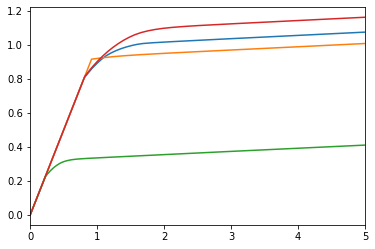

In [15]:
CyclicalExample = IndShockConsumerType(**CyclicalDict)
CyclicalExample.cycles = 0 # Make this consumer type have an infinite horizon
CyclicalExample.solve()

CyclicalExample.unpackcFunc()
print('Quarterly consumption functions:')
mMin = min([X.mNrmMin for X in CyclicalExample.solution])
plotFuncs(CyclicalExample.cFunc,mMin,5)

The very low green consumption function corresponds to the quarter in which the ski instructors make most of their income.  They know that they are about to experience a 70% drop in "permanent" income, so they do not consume much *relative to their income this quarter*.  In the other three quarters, *normalized* consumption is much higher, as current "permanent" income is low relative to future expectations.  In *level*, the consumption chosen in each quarter is much more similar